In [1]:
import numpy as np

import PIL
from PIL import ImageChops, ImageStat

from matplotlib.pyplot import imshow
%matplotlib inline

from itertools import product

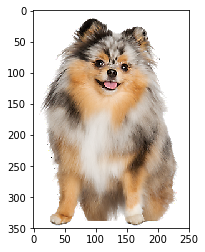

In [2]:
dog1 = PIL.Image.open('dog1.png').convert('RGB').crop((50, 0, 300, 350))

imshow(dog1)

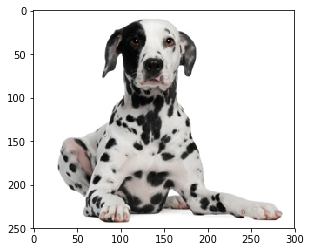

In [3]:
dog2 = PIL.Image.open('dog2.png').convert('RGB').crop((0, 35, 300, 285))

imshow(dog2)

In [4]:
def get_boxes(img, box_size=25):
    
    lx = range(0, img.size[0] + box_size, box_size)
    ly = range(0, img.size[1] + box_size, box_size)
    
    return [(tx[0], ty[0], tx[1], ty[1]) for tx, ty in product(zip(lx[:-1], lx[1:]), zip(ly[:-1], ly[1:]), repeat=True)]

# calc_boxes((75, 50))

In [5]:
def is_whitespace(im, threshold):
    return np.mean(ImageStat.Stat(im).mean) >= threshold

In [6]:
def get_boxes_non_blank(img, box_size, threshold):
    
    return [box for box in get_boxes(img, box_size) if not is_whitespace(img.crop(box), threshold)]

In [7]:
def calc_diff(im1, im2):
    
    return sum(ImageStat.Stat(ImageChops.difference(im1, im2)).rms)

print(calc_diff(dog1.crop((0, 0, 25, 25)), dog2.crop((0, 0, 25, 25))))
print(calc_diff(dog1.crop((0, 0, 25, 25)), dog2.crop((75, 0, 100, 25))))

0.0
86.90181152487469


In [8]:
def replace_with_closest(im1, im2, box_size=25, threshold=255, mean_filter=1.0):
    
    assert 0 <= threshold <= 255
    assert 0.0 <= mean_filter <= 1.0
    
    imo = im1.copy()
    
    boxes1 = get_boxes_non_blank(im1, box_size, threshold)
    boxes2 = get_boxes_non_blank(im2, box_size, threshold)
    
    c2s = [im2.crop(box2) for box2 in boxes2]
    c2s_mean = np.array([ImageStat.Stat(c2).mean for c2 in c2s])
    
    err_tot = 0
        
    for box1 in boxes1:
                
        c1 = im1.crop(box1)
        err_old = None
        
        # pre-filtering here
        if mean_filter < 1:
            c_diff = ((c2s_mean - np.array(ImageStat.Stat(c1).mean)) ** 2).sum(1)
            c2s_f = [c2s[i] for i in np.argsort(c_diff)[:int(len(c_diff) * mean_filter)]]
        else:
            c2s_f = c2s
        
        for c2 in c2s_f:
            for deg in [0, 90, 180, 270]:
                
                c2_r = c2.rotate(deg)
                err_new = calc_diff(c1, c2_r)

                if (err_old is None) or (err_new < err_old):
                    c2_use = c2_r
                    err_old = err_new
        
        imo.paste(c2_use, box1)
        err_tot += err_old
        
    print(err_tot)
                
    return imo

45992.65936240772
Wall time: 21.8 s


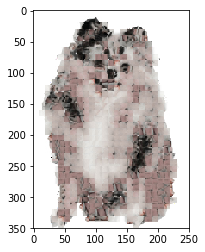

In [9]:
%%time

dog12 = replace_with_closest(dog1, dog2, 10, 250, 0.05)
        
imshow(dog12)

In [10]:
dog12.save('dog12.png')

31526.083816762923
Wall time: 22.7 s


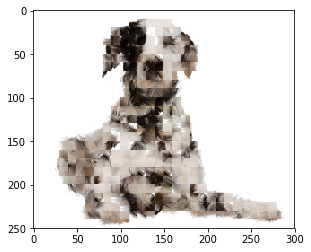

In [11]:
%%time

dog21 = replace_with_closest(dog2, dog1, 10, 250, 0.05)
        
imshow(dog21)

In [12]:
dog21.save('dog21.png')